# Predicting News Article Popularity 

## Business Understanding 

Advertising on social media has empowered new and smaller media companies to publish textual content to a broader audience, which can then further spread their content. This presents the decision to make about which content to advertise or share in order to maximize the publisher’s reach. For even the smallest publishers, this decision can be supported with simple machine learning models analyzing content metadata. 

## Data Understanding 

In order to show how social media popularity for textual media can be modeled, article metadata was gathered from the New York Time's API website. Although one of the largest publishers of news articles, the data is of very high quality and should resemble what other companies have access to in-house. 

Two APIs were used. First, the __[NYT Archive API](https://developer.nytimes.com/docs/archive-product/1/overview)__,  which returns every article for a given range of months and years. Second, the __[NYT Most Popular API](https://developer.nytimes.com/docs/most-popular-product/1/overview)__, which returns the most popular articles on NYTimes.com based on emails, Facebook shares, or views on the NYT site. For this project Facebook shares were chosen and calls were made to the API once per day to gather that day's top 20 list. Articles in the archive that were listed on a top 20 list were then labeled as a popular article for a modeling target.  

#### Importing the required packages

In [1]:
# file manipulation 
import os

# data manipulation 
import re
import datetime as dt
import pandas as pd
import numpy as np
import math
from functions import *

# modeling 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, plot_confusion_matrix, plot_roc_curve

# sampling
from imblearn.over_sampling import SMOTE

# preprocessing text
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 


# plotting 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

#### Loading the data
The scripts to request, clean and store both the article archive data and the daily top 20 most shared on Facebook lists can be found in [request_archive.py](./request_archive.py) and [request_most_shared_articles.py](./request_most_shared_articles.py). One request for a top 20 list for the previous 30 days was made to help label some articles in the archive as popular that were published before daily collection of a top 20 list was begun. 

The archive data contains all articles from December and all from January up to the end of the training phase on January 15th. Any rows with Null values in the archive were dropped and the date published column was changed to the datetime data type. The metadate that was collected for modeling was the headline of the article, keywords for the article, a snippet from the article and the word count for the article. Additionally the URI and date published was grabbed for each article. 

For each top 20 list the URI, date published and date the list was sourced was taken. 

In [103]:
# load archive articles from csv in data directory
df = pd.read_csv('data/exp_archive.csv')
df.date_published = df.date_published.apply(lambda x: pd.to_datetime(x).date())
cutoff_date = pd.to_datetime('2022-01-07').date()
last_training_day = pd.to_datetime('2022/01/15').date()
df = df[(df.date_published >= cutoff_date)&(df.date_published <= last_training_day)]
df.dropna(inplace=True)

# load seperate top 20 lists in folder in data directory into single dataframe 
df_most_shared = load_most_shared('data/most_popular_train')

<br>
A list was made to house the URI's, the unique index for each article, for articles appearing on a top 20 list at least once. Then a popular column was created for the archive dataframe by iterating over the list of the highly shared articles and assigning a 0 if that article's URI was not present on the list and 1 for if it was. This is the target column for the models.

In [104]:
# create list, then interate over it to make target column
popular_list = df_most_shared.uri.values
df['popular'] = [1 if x in popular_list else 0 for x in df.uri.values]

In [105]:
# view the dataframe
df.head()

,uri,date_published,headline,keywords,paragraph,word_count,popular
4588,nyt://article/9a39725e-999c-5ca0-bd57-530b3864...,2022-01-07,jamie raskin’s year of tragedy and trump,united states politics and governmentstorming ...,"hi. welcome to on politics, your guide to the ...",1516,0
4589,nyt://article/23b1e58f-74d9-5959-b63b-551d56a6...,2022-01-07,the economic case for goldilocks,inflation (economics)labor and jobscoronavirus...,"for the u.s. economy, 2021 was both the best o...",887,0
4590,nyt://article/c60e5ca3-b3ab-56dd-ae03-e64d09a3...,2022-01-07,why democrats are so bad at defending democracy,"voting rights, registration and requirementsab...","when it comes to elections, the republican par...",956,0
4591,nyt://article/64fe533c-78bf-5e8a-8cc3-718e22f5...,2022-01-07,ignoring trump didn’t work. biden goes after ‘...,"storming of the us capitol (jan, 2021)biden, j...",washington — for most of his first year in off...,1411,0
4592,nyt://article/3262ab56-5372-55d5-87a5-f072bf2a...,2022-01-07,former biden advisers urge a pandemic strategy...,"coronavirus (2019-ncov)biden, joseph r jrunite...",washington — on the day president biden was in...,1425,0


## Exploratory Data Analysis  
Checking `df.info()` shows that both DataFrame individually have equal values with no Null values to take care of. It also shows that the datatypes are what we expect and want. 

In [106]:
print(df.info())
print()
print(df_most_shared.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1047 entries, 4588 to 5726
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   uri             1047 non-null   object
 1   date_published  1047 non-null   object
 2   headline        1047 non-null   object
 3   keywords        1047 non-null   object
 4   paragraph       1047 non-null   object
 5   word_count      1047 non-null   int64 
 6   popular         1047 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 65.4+ KB
None

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 2022-01-18 to 2022-01-10
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   uri             200 non-null    object
 1   date_published  200 non-null    object
dtypes: object(2)
memory usage: 4.7+ KB
None


##### Archive articles
Looking at the distribution of article popularity reveals massive class imbalance. Only 2% of the articles in the archive appear on a top 20 list. This is particularly because of the articles included in the archive that were published in December and January before daily top 20 lists were started to be collected. Due to the API's constraints, only the daily top 20 list from the day the request was made are available. 

,sum,percentage
popular,,
0,938,0.9
1,109,0.1


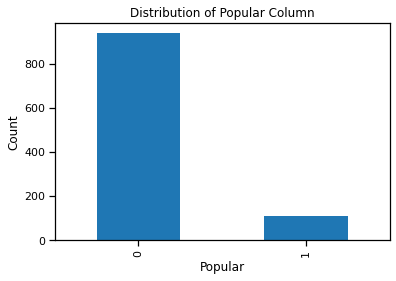

In [107]:
# function makes a dataframe to display target variable value's sum and percentage
# also, it plots the target variable's value distribution
target_distribution = summerize_value_counts(df.popular)
target_distribution

##### Top 20 most shared articles
Looking at each day's top 20 list and the distribution of dates when the articles were published originally shows that the majority of the articles on each list were published in the two days before the day of the list's creation, with a smaller proportion having been published three days before or on the day of creation.

functions used to load, clean and plot the date are found in [functions.py](./functions.py).

In [108]:
# load csv's into a list of dataframes 
df_list_load = load_most_shared_eda('data/most_popular_train')

# change date columns to datetime dtype and sort list by date of top 20 list in ascending order 
df_list = clean_most_shared_eda(df_list_load)

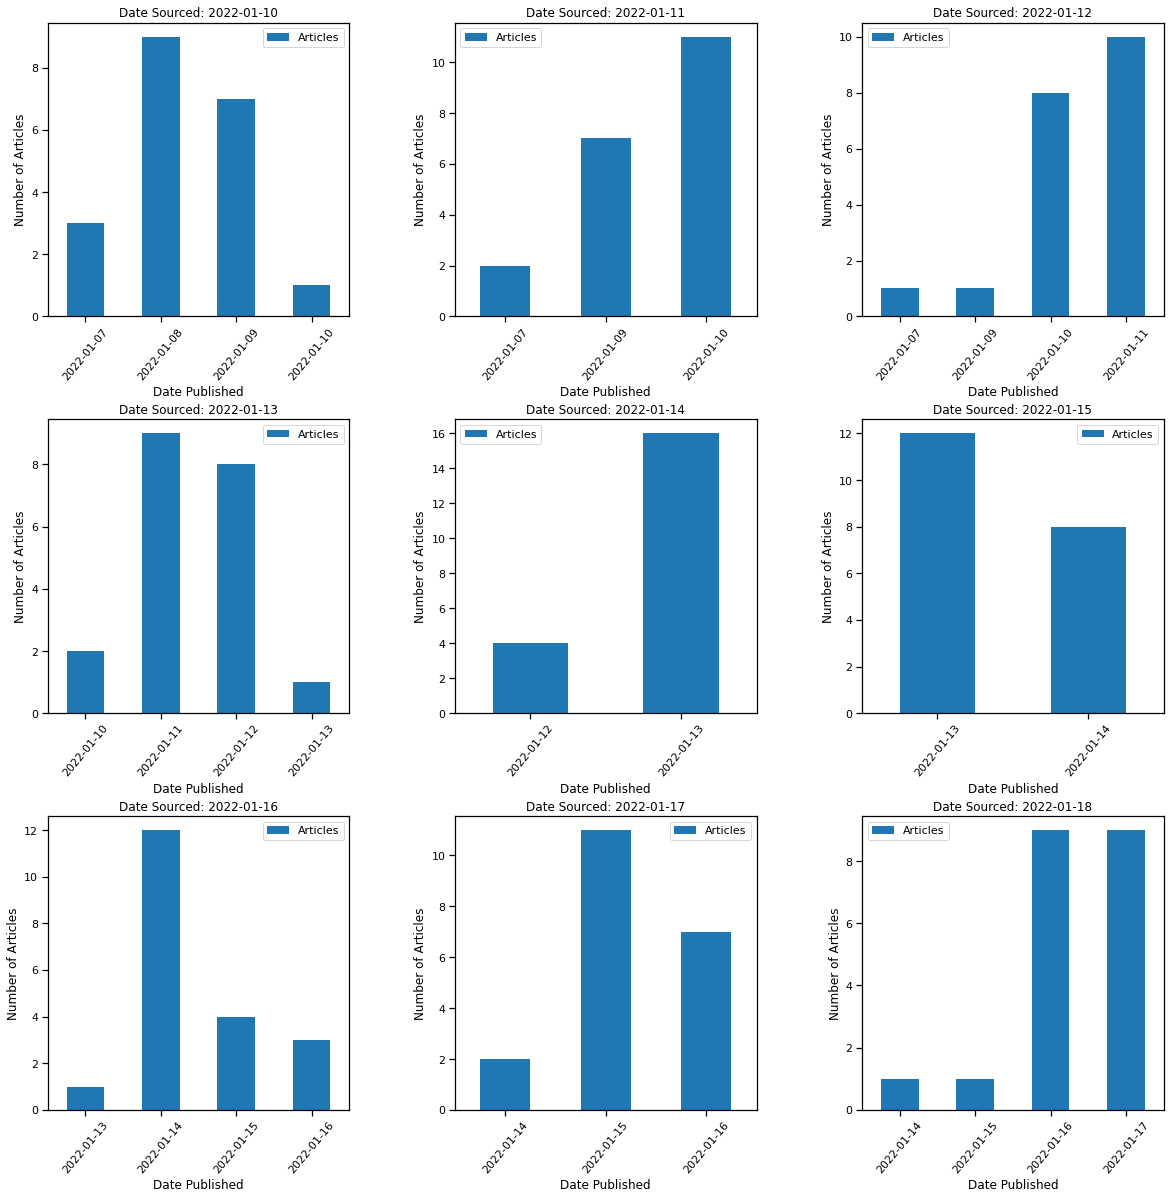

In [109]:
# generate correct amount of subplots based on length of list then plot each dataframe in list
plot_most_shared(df_list)

,percentage
0 days,3%
1 days,44%
2 days,45%
3 days,6%
4 days,2%
5 days,1%


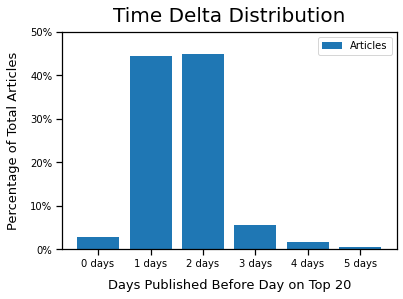

In [110]:
time_delta, top_20_df = top_20_delta_perc(df_list)
top_20_df

## Data Preperation

##### Train-Test Split
Features are separated from the target and a test size of 40% is selected. This is because the final model is trained with the testing data results of the models before it. To ensure it has enough training data, a relatively high test size proportion was chosen. 

Also, the random state is established as 0, which will be the state for all models going forward. 

In [111]:
# features = X, target = y
X = df.drop('popular', axis=1)
y = df.popular

In [112]:
# random state of 0 is established for the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.40)

## Dummy classifier
A baseline model is established with the data.

In [113]:
# initialize baseline model
dummy = DummyClassifier(random_state=0, strategy='stratified') 

# fit with training data and predict with test set
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

In [114]:
# baseline model accuracy 
print("Accuracy Score: {}".format(accuracy_score(y_test, y_pred)))

Accuracy Score: 0.8114558472553699


In [115]:
# count how many articles are labeled popular by predicitng probabilities
dummy_prob = dummy.predict_proba(X_test)
dummy_predict_popular = [x[1] for x in dummy_prob if x[1] == 1]
len(dummy_predict_popular)

43

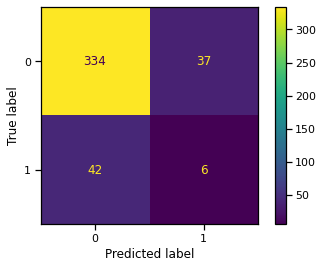

In [116]:
# plot confusion matrix to show error of the model
# 0: 'not popular', 1: 'popular'
plot_confusion_matrix(dummy, X_test, y_test);

The baseline model achieved a 95% accuracy rate, but this is due to the massive class imbalance towards articles that are not featured on the most shared list. The bottom right box in the confusion matrix shows that the baseline model correctly predicted  only 1 of the articles that were on a top 20 list.

## Data Preprocessing 

The following section will take care of both converting the textual data into numerical data and resampling the training data to address the class imbalance. This will be done separately for each feature, separating them and transforming the text features before every feature goes into their own model that will convert their values to numeric scores. After this they will eventually be rejoined in the final model for prediction of a top 20 list. 

The first differentiated preprocessing method for the textual data is how to tokenize each feature, or condense each string of text into a more meaningful version. Each of the features will be differentiated this way, with one similarity being the removal of stopwords. Stopwords are words that provide very little lexical context to a string of text based on their use in sentence construction. These words, such as "i", "me", "you", "isn't", and "wouldn't", will be removed in both of the different tokenized streams for the training data. At this point, one version of the data, the regular vectorizer, has completed tokenization. Another version will go through the extra step of lemmatization. This process' goal is to convert words in each string to a lexical stem with the help of the word's part of speech. This can combine words whose spelling differences are a reflection of being different inflected forms of the same word, rather than words with completely different meanings. This can help to further identify underlying patterns in the data. 


The second differentiated preprocessing method for the textual data, vectorizing each of the text features into a numeric matrix, will be done in two different ways for each of the two different tokenization methods, making four different streams for each of the three columns with text. This is in order to find the best preprocessing techniques for the final deployment pipelines. To differentiate vectorization, each feature will have one version go through a TfidfVectorizer and one version through a CountVectorizer. While both vectorizers transform the column of text data into a matrix where each column becomes a unique word that appears in the entire feature's column and each row a different article with numeric values under the words that appear in that article, they differ on how that numeric value is calculated. The CountVectorizer does so by  assigning a binary value of 0 and 1 to each word, where 0 indicates that the word does not appear in the article and a 1 indicates that it does. The TfidfVectorizer, on the other hand, assigns a floating point value to each word. This value is calculated by multiplying two different frequency measures together. The first measure is the words frequency in each feature of the article, or the amount of times it occurs in that article for that feature divided by the total amount of words in that feature for that article. This is then multiplied by the second measure, the Inverse Document Frequency, or the amount of articles there are in total divided by the amount of articles that contain that word for that feature.

After these preprocessing steps have occured, the class imbalance of the target variable, 'popular', is handled with SMOTE, Synthetic Minority Over-sampling Technique, resampling. This will resample the training data to include more data from the positive target class, meaning more articles that are labeled as having been featured on a top 20 most shared list will be included in order to better train the models to identify those articles. This will be done separately for each of the four distinct preprocessing methods that each of the three textual features go through. It is also the step where the fourth and final feature from the original dataset, 'word_count', is joined into this section as it is already in a numeric value that does not need any preprocessing.

### Headline

##### TfidfVectorizer

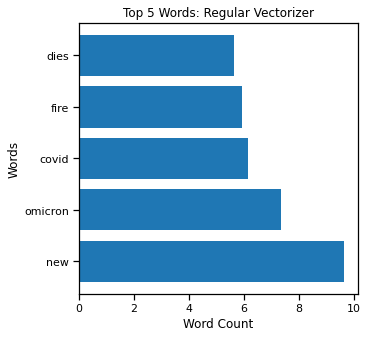

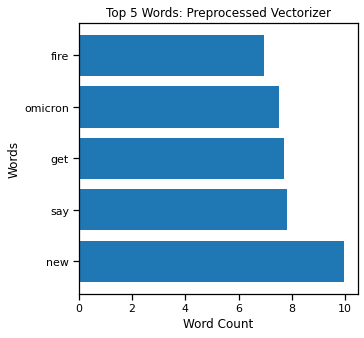

In [117]:
# regular vectorizer
headline_tf, X_train_headline_tf, X_test_headline_tf = vectorize_feature(TfidfVectorizer, 
                                                                         X_train.headline, X_test.headline)
# smote vectorized training data
X_train_headline_tf_sm, y_train_headline_tf_sm = smote_data(X_train_headline_tf, y_train,
                                                            sampling_strategy='auto',random_state=0)

# used later
# vectorizor: headline_tf
# data : X_train_headline_tf_sm, y_train_headline_tf_sm, X_test_headline_tf



# tokenize and lemmatize before vectorization
headline_tok_tf, X_train_headline_tok_tf, X_test_headline_tok_tf = tokenize_vector(TfidfVectorizer, 
                                                                                   X_train.headline, 
                                                                                   X_test.headline)
# smote preprocessed vectorized training data
X_train_headline_tok_tf_sm, y_train_headline_tok_tf_sm = smote_data(X_train_headline_tok_tf, y_train,
                                                                    sampling_strategy='auto',random_state=0)

# used later
# vectorizor: headline_tok_tf
# data : X_train_headline_tok_tf_sm, y_train_headline_tok_tf_sm, X_test_headline_tok_tf

plot_top_words(headline_tf, X_train_headline_tf, 'Regular Vectorizer');
plot_top_words(headline_tok_tf, X_train_headline_tok_tf, 'Preprocessed Vectorizer');

##### CountVectorizer

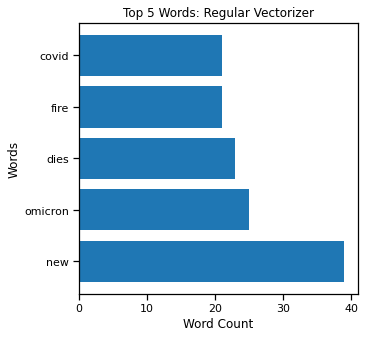

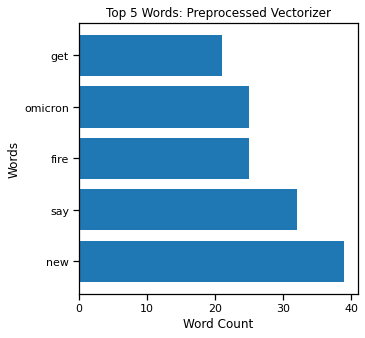

In [118]:
# regular vectorizer
headline_cv, X_train_headline_cv, X_test_headline_cv = vectorize_feature(CountVectorizer, 
                                                                         X_train.headline, X_test.headline)
# smote vectorized training data
X_train_headline_cv_sm, y_train_headline_cv_sm = smote_data(X_train_headline_cv, y_train, 
                                                            sampling_strategy='auto',random_state=0)

# used later
# vectorizor: headline_cv
# data: X_train_headline_cv_sm, y_train_headline_cv_sm, X_test_headline_cv



# tokenize and lemmatize before vectorization
headline_tok_cv, X_train_headline_tok_cv, X_test_headline_tok_cv = tokenize_vector(CountVectorizer, 
                                                                                   X_train.headline, 
                                                                                   X_test.headline)
# smote preprocessed vectorized training data
X_train_headline_tok_cv_sm, y_train_headline_tok_cv_sm = smote_data(X_train_headline_tok_cv, y_train,
                                                                    sampling_strategy='auto',random_state=0)

# used later
# vectorizor: headline_tok_cv
# data: X_train_headline_tok_cv_sm, y_train_headline_tok_cv_sm, X_test_headline_tok_cv

plot_top_words(headline_cv, X_train_headline_cv, 'Regular Vectorizer');
plot_top_words(headline_tok_cv, X_train_headline_tok_cv, 'Preprocessed Vectorizer');

### Keywords

##### TfidfVectorizer

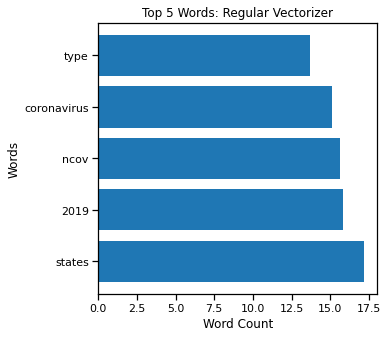

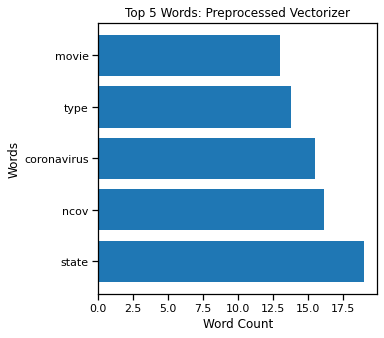

In [119]:
# regular vectorizer
keywords_tf, X_train_keywords_tf, X_test_keywords_tf = vectorize_feature(TfidfVectorizer, 
                                                                         X_train.keywords, X_test.keywords)
# smote vectorized training data
X_train_keywords_tf_sm, y_train_keywords_tf_sm = smote_data(X_train_keywords_tf, y_train, 
                                                            sampling_strategy='auto',random_state=0)

# used later
# vectorizor: keywords_tf
# data: X_train_keywords_tf_sm, y_train_keywords_tf_sm, X_test_keywords_tf



# tokenize and lemmatize before vectorization
keywords_tok_tf, X_train_keywords_tok_tf, X_test_keywords_tok_tf = tokenize_vector(TfidfVectorizer, 
                                                                                   X_train.keywords, 
                                                                                   X_test.keywords)
# smote preprocessed vectorized training data
X_train_keywords_tok_tf_sm, y_train_keywords_tok_tf_sm = smote_data(X_train_keywords_tok_tf, y_train, 
                                                                    sampling_strategy='auto',random_state=0)

# used later
# vectorizor: keywords_tok_tf
# data: X_train_keywords_tok_tf_sm, y_train_keywords_tok_tf_sm, X_test_keywords_tok_tf

plot_top_words(keywords_tf, X_train_keywords_tf, 'Regular Vectorizer');
plot_top_words(keywords_tok_tf, X_train_keywords_tok_tf, 'Preprocessed Vectorizer');

##### CountVectorizer

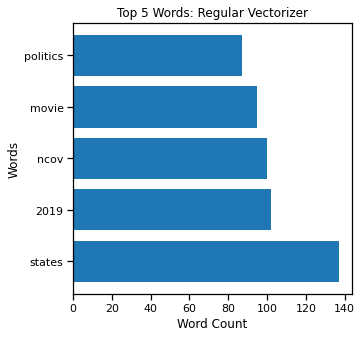

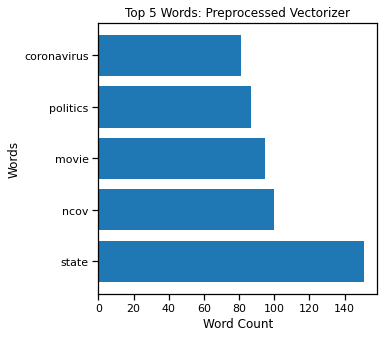

In [120]:
# regular vectorizer
keywords_cv, X_train_keywords_cv, X_test_keywords_cv = vectorize_feature(CountVectorizer, 
                                                                         X_train.keywords, X_test.keywords)
# smote vectorized training data
X_train_keywords_cv_sm, y_train_keywords_cv_sm = smote_data(X_train_keywords_cv, y_train, 
                                                            sampling_strategy='auto',random_state=0)

# used later
# vectorizor: keywords_cv
# data: X_train_keywords_cv_sm, y_train_keywords_cv_sm, X_test_keywords_cv



# tokenize and lemmatize before vectorization
keywords_tok_cv, X_train_keywords_tok_cv, X_test_keywords_tok_cv = tokenize_vector(CountVectorizer, 
                                                                                   X_train.keywords, 
                                                                                   X_test.keywords)
# smote preprocessed vectorized training data
X_train_keywords_tok_cv_sm, y_train_keywords_tok_cv_sm = smote_data(X_train_keywords_tok_cv, y_train, 
                                                                    sampling_strategy='auto',random_state=0)

# used later
# vectorizor: keywords_tok_cv
# data: X_train_keywords_tok_cv_sm, y_train_keywords_tok_cv_sm, X_test_keywords_tok_cv

plot_top_words(keywords_cv, X_train_keywords_cv, 'Regular Vectorizer');
plot_top_words(keywords_tok_cv, X_train_keywords_tok_cv, 'Preprocessed Vectorizer');

### Lead Paragraph

##### TfidfVectorizer

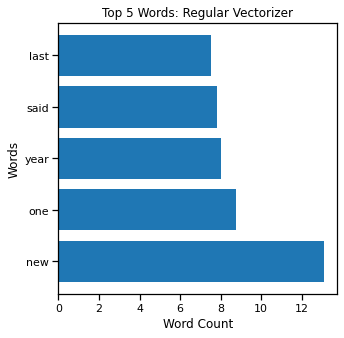

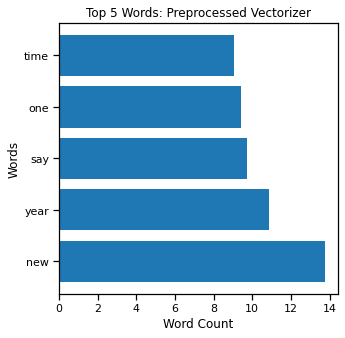

In [121]:
# regular vectorizer
paragraph_tf, X_train_paragraph_tf, X_test_paragraph_tf = vectorize_feature(TfidfVectorizer, 
                                                                         X_train.paragraph, X_test.paragraph)
# smote vectorized training data
X_train_paragraph_tf_sm, y_train_paragraph_tf_sm = smote_data(X_train_paragraph_tf, y_train, 
                                                          sampling_strategy='auto',random_state=0)

# used later
# vectorizor: snippet_tf
# data: X_train_snippet_tf_sm, y_train_snippet_tf_sm, X_test_snippet_tf



# tokenize and lemmatize before vectorization
paragraph_tok_tf, X_train_paragraph_tok_tf, X_test_paragraph_tok_tf = tokenize_vector(TfidfVectorizer, 
                                                                                X_train.paragraph, 
                                                                                X_test.paragraph)
# smote preprocessed vectorized training data
X_train_paragraph_tok_tf_sm, y_train_paragraph_tok_tf_sm = smote_data(X_train_paragraph_tok_tf, y_train, 
                                                                  sampling_strategy='auto',random_state=0)

# used later
# vectorizor: snippet_tok_tf
# data: X_train_snippet_tok_tf_sm, y_train_snippet_tok_tf_sm, X_test_snippet_tok_tf

plot_top_words(paragraph_tf, X_train_paragraph_tf, 'Regular Vectorizer');
plot_top_words(paragraph_tok_tf, X_train_paragraph_tok_tf, 'Preprocessed Vectorizer');

##### CountVectorizer

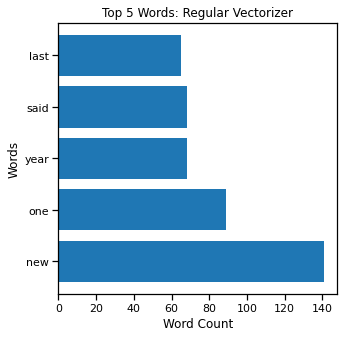

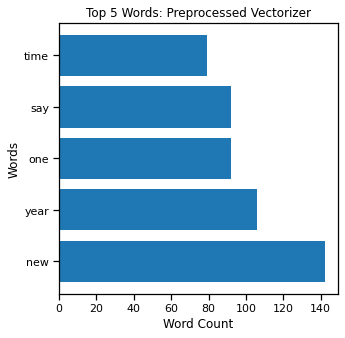

In [122]:
# regular vectorizer
paragraph_cv, X_train_paragraph_cv, X_test_paragraph_cv = vectorize_feature(CountVectorizer,
                                                                      X_train.paragraph, X_test.paragraph)
# smote vectorized training data
X_train_paragraph_cv_sm, y_train_paragraph_cv_sm = smote_data(X_train_paragraph_cv, y_train, 
                                                          sampling_strategy='auto', random_state=0)
# used later
# vectorizor: snippet_cv
# data: X_train_snippet_cv_sm, y_train_snippet_cv_sm, X_test_snippet_cv



# tokenize and lemmatize before vectorization
paragraph_tok_cv, X_train_paragraph_tok_cv, X_test_paragraph_tok_cv = tokenize_vector(CountVectorizer, 
                                                                                X_train.paragraph, 
                                                                                X_test.paragraph)
# smote preprocessed vectorized training data
X_train_paragraph_tok_cv_sm, y_train_paragraph_tok_cv_sm = smote_data(X_train_paragraph_tok_cv, y_train, 
                                                                  sampling_strategy='auto', random_state=0)
# used later
# vectorizor: snippet_tok_cv
# data: X_train_snippet_tok_cv_sm, y_train_snippet_tok_cv_sm, X_test_snippet_tok_cv

# plot 
plot_top_words(paragraph_cv, X_train_paragraph_cv, 'Regular Vectorizer');
plot_top_words(paragraph_tok_cv, X_train_paragraph_tok_cv, 'Preprocessed Vectorizer');

### Word Count

In [123]:
# smote the word_count data
X_train_word_count_sm, y_train_word_count_sm = smote_data(X_train.word_count.values.reshape(-1, 1), 
                                                          y_train, sampling_strategy='auto',
                                                          random_state=0)

## Model Training - Text

In [124]:
# function to run a random forrest 
# returns the model and a list of proabilities 
def random_forrest_proba(X_train, y_train, X_test, y_test):
    
    # initiate random forrest and search grid for number of trees in forrest
    forrest = RandomForestClassifier(random_state=0)
    grid = {'n_estimators': [50,75,100]}
    
    # create grid search and fit model with training data
    gs = GridSearchCV(estimator=forrest, param_grid=grid, cv=5, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # store predicted probabilities that article is a popular article in a list 
    class_probability = gs.predict_proba(X_test)
    target_probability = [x[1] for x in class_probability]
    
    # print model accuracy 
    score = gs.score(X_test, y_test)
    print(f'mean accuracy: {score}')
    
    # print correlation
    print(f'correlation: {round(np.corrcoef(target_probability, y_test)[0][1], 2)}')
    
    # plot an ROC curve 
    fig, ax = plt.subplots()
    plt.title('ROC Curve')
    plot_roc_curve(gs, X_train, y_train, name='Train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='Test', ax=ax)
    
    # plot confusion matrix
    plot_confusion_matrix(gs, X_test, y_test)
    
    return gs, target_probability

In [125]:
# function to run a random forrest 
# returns the model and a list of class labels 
def random_forrest_class(X_train, y_train, X_test, y_test):
    
    # initiate random forrest and search grid for number of trees in forrest
    forrest = RandomForestClassifier(random_state=0)
    grid = {'n_estimators': [50,75,100]}
    
    # create grid search and fit model with training data
    gs = GridSearchCV(estimator=forrest, param_grid=grid, cv=5, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # store predicted class labels in list 
    class_prediction = gs.predict(X_test)
    
    # print model accuracy
    score = gs.score(X_test, y_test)
    print(f'mean accuracy: {score}')
    
    # print correlation
    print(f'correlation: {round(np.corrcoef(class_prediction, y_test)[0][1], 2)}')   
    
    # plot an ROC curve
    fig, ax = plt.subplots()
    plt.title('ROC Curve')
    plot_roc_curve(gs, X_train, y_train, name='Train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='Test', ax=ax)
    
    # plot confusion matrix
    plot_confusion_matrix(gs, X_test, y_test)
    
    return gs, class_prediction

### Headline

##### Predict Probability after TfidfVectorizer

mean accuracy: 0.8854415274463007
correlation: 0.04
number of probabilities: 419



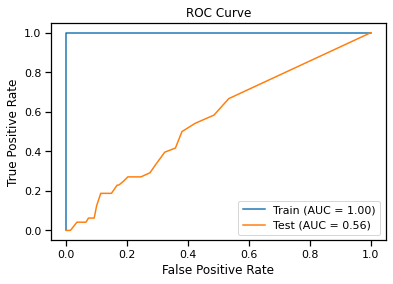

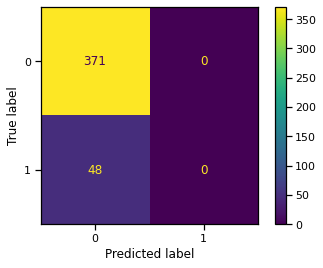

In [126]:
# run random forrest
headline_proba_rf, headline_proba = random_forrest_proba(X_train_headline_tf_sm, y_train_headline_tf_sm, 
                                                         X_test_headline_tf, y_test)
# check output length for rejoining of data
print(f'number of probabilities: {len(headline_proba)}')
print()

##### Predict Probability after Preprocessed TfidfVectorizer

mean accuracy: 0.8854415274463007
correlation: 0.06
number of probabilities: 419



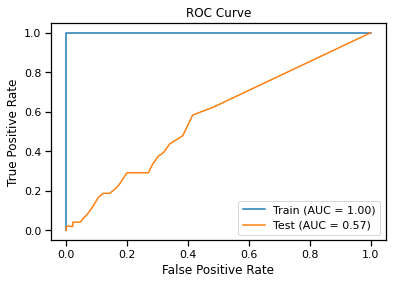

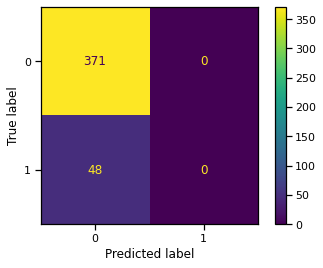

In [127]:
# run random forrest
headline_proba_rf_tok, headline_proba_tok = random_forrest_proba(X_train_headline_tok_tf_sm, 
                                                                 y_train_headline_tok_tf_sm,
                                                                 X_test_headline_tok_tf, y_test)
# check output length for rejoining of data
print(f'number of probabilities: {len(headline_proba_tok)}')
print()

##### Predict Class after CountVectorizer

mean accuracy: 0.5011933174224343
correlation: 0.0
number of class predictions: 419



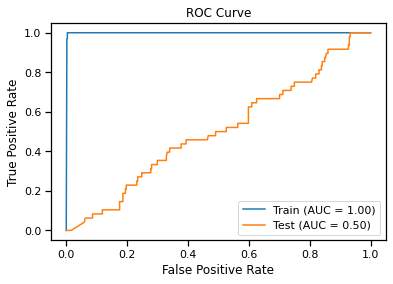

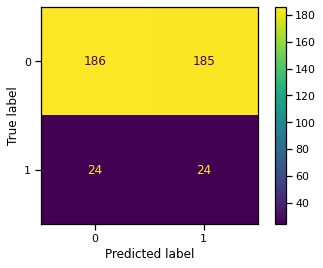

In [128]:
# run random forrest
headline_class_rf, headline_class = random_forrest_class(X_train_headline_cv_sm, y_train_headline_cv_sm, 
                                                         X_test_headline_cv, y_test)
# check output length for rejoining of data
print(f'number of class predictions: {len(headline_class)}')
print()

##### Predict Class after Preprocessed CountVectorizer

mean accuracy: 0.4677804295942721
correlation: 0.07
number of class predictions: 419



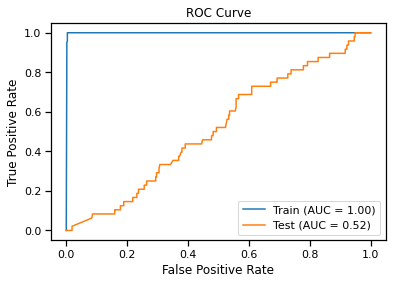

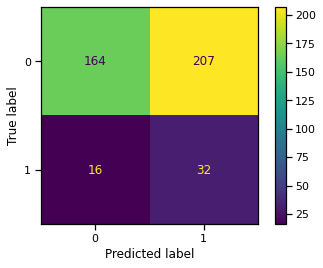

In [129]:
# run random forrest
headline_class_rf_tok, headline_class_tok = random_forrest_class(X_train_headline_tok_cv_sm, 
                                                                 y_train_headline_tok_cv_sm,
                                                                 X_test_headline_tok_cv, y_test)
# check output length for rejoining of data
print(f'number of class predictions: {len(headline_class_tok)}')
print()

### Keywords

##### Predict Probability after TfidfVectorizer

mean accuracy: 0.8806682577565632
correlation: 0.12
number of probabilities: 419



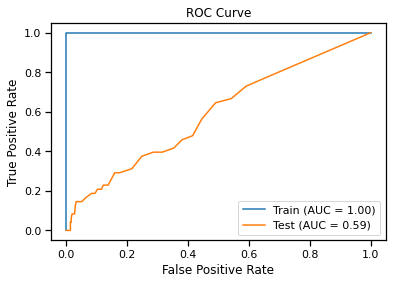

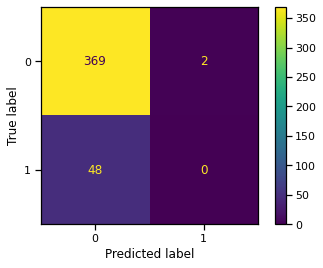

In [130]:
# run random forrest
keywords_proba_rf, keywords_proba = random_forrest_proba(X_train_keywords_tf_sm, y_train_keywords_tf_sm, 
                                                         X_test_keywords_tf, y_test)
# check output length for rejoining of data
print(f'number of probabilities: {len(keywords_proba)}')
print()

##### Predict Probability after Preprocessed TfidfVectorizer

mean accuracy: 0.883054892601432
correlation: 0.12
number of probabilities: 419



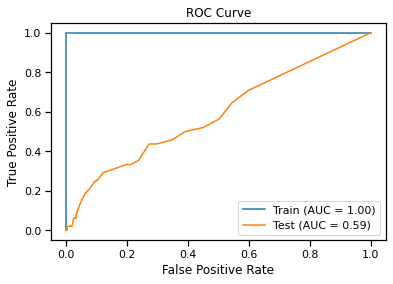

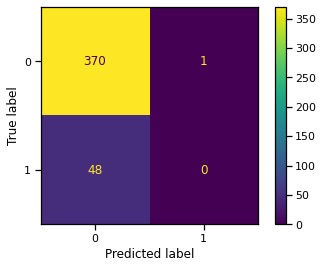

In [131]:
# run random forrest
keywords_proba_rf_tok, keywords_proba_tok = random_forrest_proba(X_train_keywords_tok_tf_sm, 
                                                                 y_train_keywords_tok_tf_sm, 
                                                                 X_test_keywords_tok_tf, y_test)
# check output length for rejoining of data
print(f'number of probabilities: {len(keywords_proba_tok)}')
print()

##### Predict Class after CountVectorizer

mean accuracy: 0.5847255369928401
correlation: 0.0
number of class predictions: 419



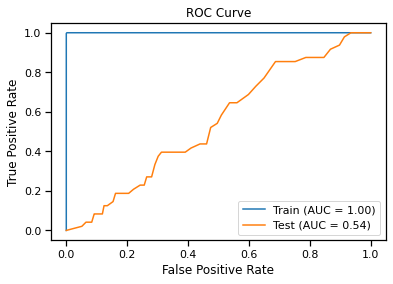

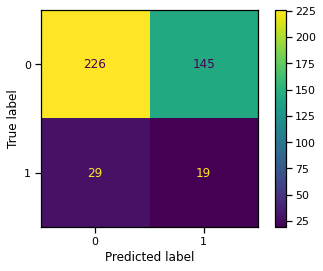

In [132]:
# run random forrest
keywords_class_rf, keywords_class = random_forrest_class(X_train_keywords_cv_sm, y_train_keywords_cv_sm, 
                                                         X_test_keywords_cv, y_test)
# check output length for rejoining of data
print(f'number of class predictions: {len(keywords_class)}')
print()

##### Predict Class after Preprocessed CountVectorizer

mean accuracy: 0.5059665871121718
correlation: -0.07
number of class predictions: 419



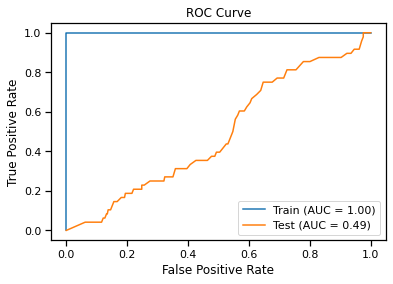

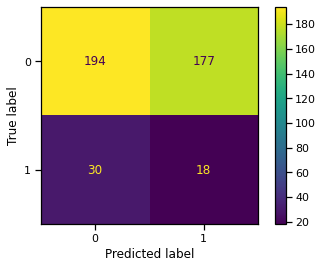

In [133]:
# run random forrest
keywords_class_rf_tok, keywords_class_tok = random_forrest_class(X_train_keywords_tok_cv_sm, 
                                                                 y_train_keywords_tok_cv_sm, 
                                                                 X_test_keywords_tok_cv, y_test)
# check output length for rejoining of data
print(f'number of class predictions: {len(keywords_class_tok)}')
print()

### Lead Paragraph 

##### Predict Probability after TfidfVectorizer

mean accuracy: 0.883054892601432
correlation: 0.08
number of probabilities: 419



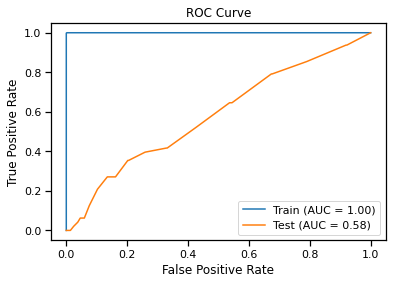

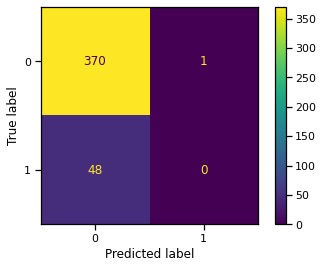

In [134]:
# run random forrest
para_paragraph_rf, paragraph_proba = random_forrest_proba(X_train_paragraph_tf_sm, y_train_paragraph_tf_sm, 
                                                       X_test_paragraph_tf, y_test)
# check output length for rejoining of data
print(f'number of probabilities: {len(paragraph_proba)}')
print()

##### Predict Probability after Preprocessed TfidfVectorizer

mean accuracy: 0.8854415274463007
correlation: 0.09
number of probabilities: 419



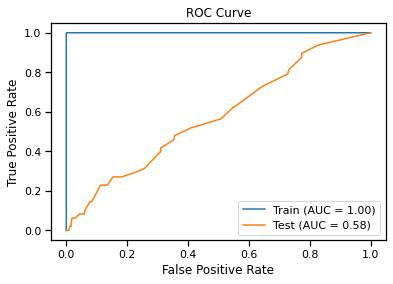

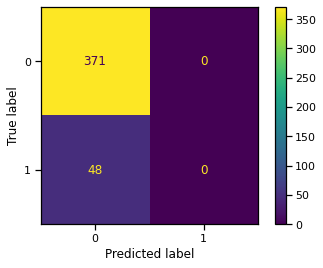

In [135]:
# run random forrest
paragraph_proba_rf_tok, paragraph_proba_tok = random_forrest_proba(X_train_paragraph_tok_tf_sm, 
                                                               y_train_paragraph_tok_tf_sm,
                                                               X_test_paragraph_tok_tf, y_test)
# check output length for rejoining of data
print(f'number of probabilities: {len(paragraph_proba_tok)}')
print()

##### Predict Class after CountVectorizer

mean accuracy: 0.7183770883054893
correlation: -0.1
number of class predictions: 419



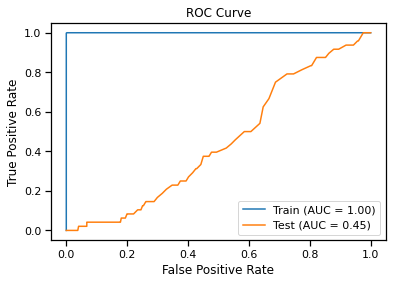

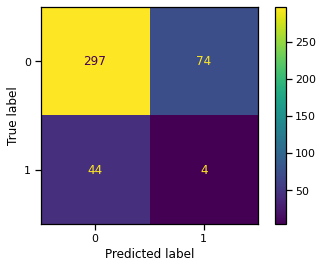

In [136]:
# run random forrest
paragraph_class_rf, paragraph_class = random_forrest_class(X_train_paragraph_cv_sm, y_train_paragraph_cv_sm, 
                                                       X_test_paragraph_cv, y_test)
# check output length for rejoining of data
print(f'number of class predictions: {len(paragraph_class)}')
print()

##### Predict Class after Preprocessed CountVectorizer

mean accuracy: 0.6754176610978521
correlation: -0.05
number of class predictions: 419



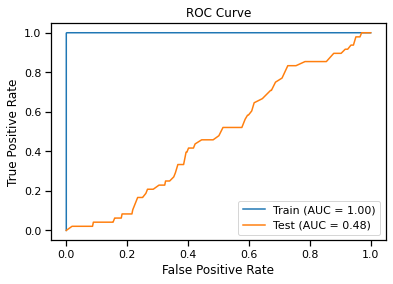

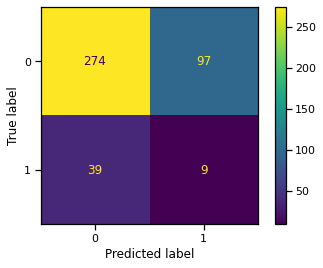

In [137]:
# run random forrest
paragraph_class_rf_tok, paragraph_class_tok = random_forrest_class(X_train_paragraph_tok_cv_sm, 
                                                               y_train_paragraph_tok_cv_sm,
                                                               X_test_paragraph_tok_cv, y_test)
# check output length for rejoining of data
print(f'number of class predictions: {len(paragraph_class_tok)}')
print()

## Model Training - Numeric

### Word Count

In [138]:
# function to run a logistic regression 
# returns the model, a list of proabilities, and a list of class labels 
def log_regression_word_count(X_train, y_train, X_test, y_test):
    
    # initiate logsitic regression and fit with training data 
    clf = LogisticRegression(random_state=0)
    clf.fit(X_train, y_train)
    
    # store predicted class labels in list 
    class_prediction = clf.predict(X_test.values.reshape(-1, 1))
    
    # store predicted probabilities that article is a popular article in a list
    probabilities = clf.predict_proba(X_test.values.reshape(-1, 1))
    probabilities = [x[1] for x in probabilities]
    
    # print model accuracy
    score = clf.score(X_test.values.reshape(-1, 1), y_test)
    print(f'mean accuracy: {score}')
    
    # print correlations
    print(f'proba correlation: {round(np.corrcoef(probabilities, y_test)[0][1], 2)}') 
    print(f'class correlation: {round(np.corrcoef(class_prediction, y_test)[0][1], 2)}') 
    
    # plot an ROC curve
    fig, ax = plt.subplots()
    plt.title('ROC Curve')
    plot_roc_curve(clf, X_train, y_train, name='Train', ax=ax)
    plot_roc_curve(clf, X_test.values.reshape(-1, 1), y_test, name='Test', ax=ax);
    
    # plot confusion matrix
    plot_confusion_matrix(clf, X_test.values.reshape(-1, 1), y_test)
    
    return clf, probabilities, class_prediction

mean accuracy: 0.5704057279236276
proba correlation: 0.06
class correlation: 0.09
number of probabilities: 419
number of class predictions: 419



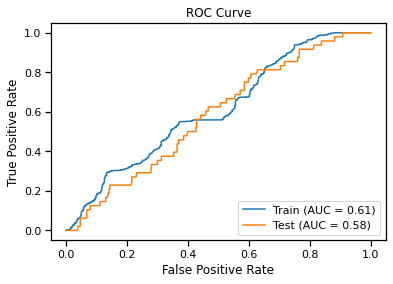

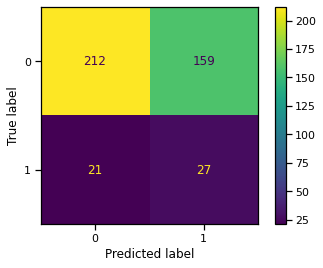

In [139]:
# run logistic regression
word_count_log_reg, word_count_proba, word_count_class = log_regression_word_count(X_train_word_count_sm, 
                                                                                   y_train_word_count_sm, 
                                                                                   X_test.word_count, y_test)
# check output length for rejoining of data
print(f'number of probabilities: {len(word_count_proba)}')
print(f'number of class predictions: {len(word_count_class)}')
print()

In [140]:
import numpy as np
np.corrcoef(word_count_proba, y_test)

array([[1.        , 0.06141886],
       [0.06141886, 1.        ]])

In [141]:
np.corrcoef(word_count_class, y_test)

array([[1.       , 0.0858512],
       [0.0858512, 1.       ]])

## Cumulative Model 

### Cleaning 

##### Proability Data

In [142]:
df_predict_proba = pd.DataFrame({'headline_prob': headline_proba, 
                                 'keywords_prob': keywords_proba, 
                                 'paragraph': paragraph_proba_tok, 
                                 'word_count_proba': word_count_proba})

In [143]:
df_predict_proba.head()

,headline_prob,keywords_prob,paragraph,word_count_proba
0,0.01,0.186667,0.306667,0.620459
1,0.00,0.026667,0.000000,0.370011
2,0.03,0.106667,0.160000,0.565573
3,0.00,0.000000,0.000000,0.349240
4,0.22,0.106667,0.053333,0.678615


In [144]:
scaler = StandardScaler()

In [145]:
df_predict_proba.iloc[:,:] = scaler.fit_transform(df_predict_proba.iloc[:,:].to_numpy())

In [146]:
df_predict_proba.head()

,headline_prob,keywords_prob,paragraph,word_count_proba
0,-0.556719,0.898505,2.674906,1.507219
1,-0.669407,-0.576416,-1.123450,-1.464031
2,-0.331342,0.161045,0.858301,0.856064
3,-0.669407,-0.822237,-1.123450,-1.710462
4,1.809740,0.161045,-0.462867,2.197165


In [147]:
df_predict_proba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   headline_prob     419 non-null    float64
 1   keywords_prob     419 non-null    float64
 2   paragraph         419 non-null    float64
 3   word_count_proba  419 non-null    float64
dtypes: float64(4)
memory usage: 13.2 KB


<br>

##### Class Labeled Data 

In [148]:
df_predict_class = pd.DataFrame({'headline_prob': headline_class, 
                                 'keywords_prob': keywords_class, 
                                 'paragraph_class': paragraph_class_tok, 
                                 'word_count_class': word_count_class})

In [149]:
df_predict_class.head()

,headline_prob,keywords_prob,paragraph_class,word_count_class
0,0,0,0,1
1,0,0,0,0
2,0,0,0,1
3,0,0,0,0
4,1,0,1,1


In [150]:
df_predict_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   headline_prob     419 non-null    int64
 1   keywords_prob     419 non-null    int64
 2   paragraph_class   419 non-null    int64
 3   word_count_class  419 non-null    int64
dtypes: int64(4)
memory usage: 13.2 KB


<br>

### Training model

,sum,percentage
popular,,
0,371,0.89
1,48,0.11


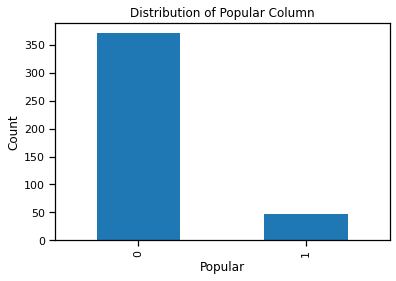

In [151]:
target_distribution_deploy = summerize_value_counts(y_test)
target_distribution_deploy



##### Predicting with Probabilities 

In [152]:
clf_proba = LogisticRegression()

In [153]:
clf_proba.fit(df_predict_proba, y_test)

LogisticRegression()

<br>

##### Predicitng with class labels

In [154]:
clf_class = LogisticRegression()

In [155]:
clf_class.fit(df_predict_class, y_test)

LogisticRegression()

## Model Deployment

In [60]:
pd.to_datetime('01/18/22').date()

datetime.date(2022, 1, 18)

In [158]:
df_archive_deploy = pd.read_csv('data/exp_archive.csv')
df_archive_deploy.date_published = df_archive_deploy.date_published.apply(lambda x: pd.to_datetime(x).date())
df_archive_deploy = df_archive_deploy[df_archive_deploy.date_published > last_training_day]
df_archive_deploy.dropna(inplace=True)

df_most_shared_deploy = load_most_shared('data/most_popular_deploy')

In [159]:
prediction_day = '01/18/22'
prediction_day = pd.to_datetime(prediction_day).date()
prediction_day

datetime.date(2022, 1, 18)

In [160]:
# delta_dict = time_delta.to_dict()
# delta_dict

In [163]:
def filter_predction_dfs(df_archive, df_shared, day_of_predict, delta=3):
    
    time_delta = dt.timedelta(days=delta)
    cutoff_day = day_of_predict - time_delta
    
    df_deploy = df_archive[(df_archive.date_published >= cutoff_day) & 
                             (df_archive.date_published <= day_of_predict)]
    
    article_ids = df_deploy['uri']
    date_published = df_deploy['date_published']
#     delta_correction = [delta_dict[abs(x - prediction_day)] for x in test.date_published]
    df_feature_deploy = df_deploy[['headline','keywords','paragraph','word_count']]
    
    df_top_20 = df_shared[df_shared.index == day_of_predict]
    
    return article_ids, date_published, df_feature_deploy, df_top_20

In [164]:
deployed_article_ids, date_published, df_feature_deploy, df_top_20 = filter_predction_dfs(df_archive_deploy, 
                                                                          df_most_shared_deploy, 
                                                                          prediction_day, delta=3)

In [165]:
deployed_article_ids

5728    nyt://article/788eb893-2dca-567a-9ba8-91e7897a...
5729    nyt://article/f00468d9-8c85-5141-a5a4-8b592f6a...
5732    nyt://article/45bfef70-a4e6-5211-b9f4-95c9acfc...
5733    nyt://article/09084cca-4f23-5fb1-8d82-5c01e336...
5734    nyt://article/ad52d330-1f21-51a4-98d0-b2b355d0...
                              ...                        
5989    nyt://article/a5ef1354-9877-54ee-a04a-31727951...
5990    nyt://article/186371ca-e156-5840-8759-23eb4c38...
5991    nyt://article/40a9076f-69be-5055-9803-b89a62ae...
5992    nyt://article/b896350c-9630-5744-83e7-f04f30c6...
5993    nyt://article/b50f3c32-fe27-5e5d-a513-769ea30d...
Name: uri, Length: 246, dtype: object

In [170]:
date_published.value_counts()

2022-01-18    109
2022-01-17     72
2022-01-16     65
Name: date_published, dtype: int64

In [171]:
df_feature_deploy.shape

(246, 4)

In [172]:
str(df_top_20.index[0])

'2022-01-18'

In [173]:
def predict_with_probabilities():
    
    headline = df.headline
    keywords = df.keywords
    snippet = df.snippet
    word_count = df.word_count
    
    headline_tf_vec.transform()
    headline_tf_vec_tok.transform()
    headline_proba_rf.predict_proba()
    
    keywords_tf_vec.transform
    keywords_tf_vec_tok.transform
    keywords_proba_rf.predict_proba
    
    snippet_tf_vec.transform
    snippet_tf_vec_tok.transform
    snippet_proba_rf.predict_proba
    
    word_count_log_reg.predict_proba

    

In [174]:
def predict_with_class_labels(df):
    
    headline = df.headline
    keywords = df.keywords
    snippet = df.snippet
    word_count = df.word_count
    
    headline_cv_vec.transform
    headline_cv_vec_tok.transform
    headline_class_rf.predict
    
    keywords_cv_vec.transform
    keywords_cv_vec_tok.transform
    keywords_class_rf.predict
    
    snippet_cv_vec.transform
    snippet_cv_vec_tok.transform
    snippet_class_rf.predict
    
    word_count_log_reg.predict
    
    

In [175]:
# paragraph_tok_tf, paragraph_proba_rf_tok
# paragraph_tok_cv, paragraph_class_rf_tok

In [176]:
headline_proba_pipe = Pipeline([('headline_tf', headline_tf), 
                                ('headline_proba_rf', headline_proba_rf)])

In [177]:
keywords_proba_pipe = Pipeline([('keywords_tf', keywords_tf), 
                                ('keywords_proba_rf', keywords_proba_rf)])

In [178]:
paragraph_proba_pipe = Pipeline([('paragraph_tok_tf', paragraph_tok_tf), 
                               ('paragraph_proba_rf_tok', paragraph_proba_rf_tok)])

In [179]:
def proba_nlp_pipeline(features, index):
    
    headline_probs = headline_proba_pipe.predict_proba(features.headline)
    headline_probs = [x[1] for x in headline_probs]
    
    keywords_probs = keywords_proba_pipe.predict_proba(features.keywords)
    keywords_probs = [x[1] for x in keywords_probs]
    
    paragraph_probs  = paragraph_proba_pipe.predict_proba(features.paragraph)
    paragraph_probs = [x[1] for x in paragraph_probs]
    
    word_count_probs = word_count_log_reg.predict_proba(features.word_count.values.reshape(-1, 1))
    word_count_probs = [x[1] for x in word_count_probs]
    
    df = pd.DataFrame({'headline_probabilty': headline_probs, 
                       'keywords_probabilty': keywords_probs,
                       'paragraph_probabilty': paragraph_probs, 
                       'word_count_probabilty': word_count_probs}, index=index)
        
    scaler = StandardScaler()
    df.iloc[:, :] = scaler.fit_transform(df.iloc[:, :].to_numpy())
    
    return df

In [180]:
# test_df = pd.DataFrame(tree_details.values(), index=tree_details.keys(), columns=['Information'])

In [181]:
# headline tfidf winners: headline_tf, headline_proba_rf, headline_proba
# headline cv winners: headline_cv, headline_class_rf, headline_class

In [182]:
# keywords tfidf winners: keywords_tf, keywords_proba_rf, keywords_proba
# keywords cv winners: keywords_cv, keywords_class_rf, keywords_class

In [183]:
# snippet tfidf winners: snippet_tok_tf, snippet_proba_rf_tok, snippet_proba_tok
# snippet cv winners: snippet_tok_cv, snippet_class_rf_tok, snippet_class_tok

In [184]:
headline_class_pipe = Pipeline([('headline_cv', headline_cv), 
                                ('headline_class_rf', headline_class_rf)])

In [185]:
keywords_class_pipe = Pipeline([('keywords_cv', keywords_cv), 
                                ('keywords_class_rf', keywords_class_rf)])

In [186]:
paragraph_class_pipe = Pipeline([('paragraph_tok_cv', paragraph_tok_cv), 
                               ('paragraph_class_rf_tok', paragraph_class_rf_tok)])

In [187]:
def class_nlp_pipeline(features, index):
    
    headline_probs = headline_class_pipe.predict(features.headline)
    keywords_probs = keywords_class_pipe.predict(features.keywords)
    paragraph_probs  = paragraph_class_pipe.predict(features.paragraph)
    word_count_probs = word_count_log_reg.predict(features.word_count.values.reshape(-1, 1))
    
    df = pd.DataFrame({'headline_probabilty': headline_probs, 
                       'keywords_probabilty': keywords_probs, 
                       'paragraph_probabilty': paragraph_probs, 
                       'word_count_probabilty': word_count_probs},  index=index)
        
    return df

In [188]:
proba_for_pred = proba_nlp_pipeline(df_feature_deploy, df_feature_deploy.index)

In [189]:
proba_for_pred.head()

,headline_probabilty,keywords_probabilty,paragraph_probabilty,word_count_probabilty
5728,1.590711,0.692504,-0.642388,-1.091732
5729,-0.642474,-0.709079,0.077487,-0.396572
5732,0.778644,-0.326829,-0.102482,0.021119
5733,-0.236440,0.819921,1.877173,0.156137
5734,1.692219,1.074754,0.437424,-0.435128


In [190]:
predictions_from_proba = clf_proba.predict_proba(proba_for_pred)
predictions_from_proba = [x[1] for x in predictions_from_proba]
predictions_from_proba = pd.Series(predictions_from_proba, index=deployed_article_ids.index, 
                                   name='predictions_from_proba')
predictions_from_proba

5728    0.105234
5729    0.088595
5732    0.103550
5733    0.165034
5734    0.142592
          ...   
5989    0.066935
5990    0.072671
5991    0.080162
5992    0.071505
5993    0.064530
Name: predictions_from_proba, Length: 246, dtype: float64

In [191]:
class_for_pred = class_nlp_pipeline(df_feature_deploy, df_feature_deploy.index)

In [192]:
class_for_pred.head()

,headline_probabilty,keywords_probabilty,paragraph_probabilty,word_count_probabilty
5728,0,0,0,0
5729,1,0,0,0
5732,1,0,0,0
5733,1,1,1,1
5734,1,0,0,0


In [193]:
predictions_from_class = clf_class.predict_proba(class_for_pred)
predictions_from_class = [x[1] for x in predictions_from_class]
predictions_from_class = pd.Series(predictions_from_class, index=deployed_article_ids.index,
                                   name='predictions_from_class')
predictions_from_class

5728    0.096497
5729    0.099575
5732    0.099575
5733    0.115611
5734    0.099575
          ...   
5989    0.103246
5990    0.099575
5991    0.103246
5992    0.103246
5993    0.071364
Name: predictions_from_class, Length: 246, dtype: float64

In [194]:
top_20_from_proba = pd.DataFrame([deployed_article_ids, date_published, predictions_from_proba]).T

top_20_from_proba.sort_values('predictions_from_proba', ascending=False, inplace=True) 
top_20_from_proba = top_20_from_proba[:20]
top_20_from_proba

,uri,date_published,predictions_from_proba
5799,nyt://article/0e723422-6b71-5929-8487-2d0a7e49...,2022-01-17,0.384185
5796,nyt://article/fa264535-6958-54b0-8ad5-1f1cf625...,2022-01-17,0.373427
5825,nyt://article/e28a1219-771c-5233-8cec-51674bff...,2022-01-17,0.36459
5736,nyt://article/73e801a9-d932-5899-96ec-11d092bb...,2022-01-16,0.275429
5920,nyt://article/a135cf06-2332-5434-a9b1-5e919e60...,2022-01-18,0.258359
5910,nyt://article/325d8e75-4d50-5277-856f-980a5b9d...,2022-01-18,0.242273
5740,nyt://article/d7fafe18-cecb-5ca7-91da-ac86e943...,2022-01-16,0.219757
5738,nyt://article/4bfd4759-50e5-5817-b6ec-4b453e57...,2022-01-16,0.217824
5782,nyt://article/f60c2c42-854b-595d-a23a-50b6eb1d...,2022-01-16,0.216332
5811,nyt://article/b7f649ea-964a-566a-89f5-9d0cbf38...,2022-01-17,0.209391


In [195]:
top_20_from_class = pd.DataFrame([deployed_article_ids, date_published, predictions_from_class]).T


top_20_from_class.sort_values('predictions_from_class', ascending=False, inplace=True)
top_20_from_class = top_20_from_class[:20]
top_20_from_class

,uri,date_published,predictions_from_class
5953,nyt://article/55838c4b-787d-5390-989b-ad0dbf3a...,2022-01-18,0.158332
5830,nyt://article/d6d3e534-d405-5953-bc19-a7484021...,2022-01-17,0.158332
5867,nyt://article/6143d114-a477-5d34-bd65-6f3f9d93...,2022-01-17,0.158332
5768,nyt://article/8f6337a3-1067-567d-bfc0-7a58d131...,2022-01-16,0.158332
5755,nyt://article/2e2fc4e8-a1dd-553a-a182-cd4730bb...,2022-01-16,0.158332
5949,nyt://article/fab17565-662c-5db7-9793-b19a8294...,2022-01-18,0.158332
5857,nyt://article/96a0640a-78f6-556a-985b-5ca2881c...,2022-01-17,0.158332
5896,nyt://article/95a8de39-99e5-53d9-acbf-5053b155...,2022-01-18,0.158332
5906,nyt://article/348f0e5c-6e4e-51a7-9c22-c7ca8fca...,2022-01-18,0.158332
5846,nyt://article/9bdda95b-afd7-5bfe-a5d9-f51acde6...,2022-01-17,0.158332


In [291]:
pred_ids = top_20_from_proba.uri.values
pred_ids

array(['nyt://article/d7fafe18-cecb-5ca7-91da-ac86e94380f4',
       'nyt://article/0e723422-6b71-5929-8487-2d0a7e493c9c',
       'nyt://article/73e801a9-d932-5899-96ec-11d092bbb45e',
       'nyt://article/e28a1219-771c-5233-8cec-51674bffaf0a',
       'nyt://article/5faff9f1-f812-5900-95d2-b7eb4ec30c67',
       'nyt://article/0b018061-56cb-5893-b627-bd8672f82aa1',
       'nyt://article/fa264535-6958-54b0-8ad5-1f1cf625b8fb',
       'nyt://article/505ace74-61e5-5377-af29-7e2a25dc1de4',
       'nyt://article/6da25df5-8c75-5cec-8746-1a2f402d51cc',
       'nyt://article/0f048161-03a7-57e4-bc29-9c818a72ae28',
       'nyt://article/0b2b3a49-a2bc-58bf-89e8-e3cdc9f30a24',
       'nyt://article/4b660502-8679-5afc-afb4-c50a88ed1ff8',
       'nyt://article/b7f649ea-964a-566a-89f5-9d0cbf38ba79',
       'nyt://article/f60c2c42-854b-595d-a23a-50b6eb1dc3a1',
       'nyt://article/b24f375a-8d8c-56e5-8929-4a094ab5c15b',
       'nyt://article/f733e3f7-4925-5411-b1bd-3674140155ff',
       'nyt://article/5a

In [292]:
act_ids = df_top_20.uri.values
act_ids

array(['nyt://article/f0eae40a-c7c9-584f-a85d-d68544f5d496',
       'nyt://article/a8cd2b1d-beab-5c35-a403-6395feaa1db2',
       'nyt://article/aeff9a74-2a9b-58f3-b7ad-27aec0bb5ff4',
       'nyt://article/3e9f24a2-4313-57d0-bff3-e900f9309062',
       'nyt://article/32042f84-b000-5027-aadf-8d55047b4b44',
       'nyt://article/47ae1e8e-64e9-5d46-96df-5edfb972edab',
       'nyt://article/f60c2c42-854b-595d-a23a-50b6eb1dc3a1',
       'nyt://article/e28a1219-771c-5233-8cec-51674bffaf0a',
       'nyt://article/b7f649ea-964a-566a-89f5-9d0cbf38ba79',
       'nyt://article/c70f7f14-bf99-53c5-b0b9-b1207890a12e',
       'nyt://article/f81238c5-d68e-54d9-a6ee-4f0ccb05bc9c',
       'nyt://article/44bd060a-4fe5-56b6-86fc-05398b7e36f5',
       'nyt://article/f804a2dd-fbd8-57ae-af9a-3a4e25c07fbd',
       'nyt://article/f733e3f7-4925-5411-b1bd-3674140155ff',
       'nyt://article/2f8c0257-078c-54a6-9207-4a11a60fb8b7',
       'nyt://article/55f6b605-3986-58e8-8105-72070a0e060c',
       'nyt://article/47

In [293]:
proba_tf_pipe = [1 if x in df_top_20.uri.values else 0 for x in top_20_from_proba.uri.values]
print(sum(proba_tf_pipe))
len(proba_tf_pipe)

4


20

In [294]:
class_cv_pipe = [1 if x in df_top_20.uri.values else 0 for x in top_20_from_class.uri.values]
print(sum(class_cv_pipe))
len(class_cv_pipe)

1


20

In [196]:
def score_top20_pred(top_20_from_proba, top_20_from_class, df_top_20):
    
    date = df_top_20.index[0]
    
    proba_tf_pipe = [1 if x in df_top_20.uri.values else 0 for x in top_20_from_proba.uri.values]
    proba_tf_pipe = sum(proba_tf_pipe)/len(proba_tf_pipe)
    class_cv_pipe = [1 if x in df_top_20.uri.values else 0 for x in top_20_from_class.uri.values]
    class_cv_pipe = sum(class_cv_pipe)/len(class_cv_pipe)
    
    pred_series = pd.Series({'proba_tf_pipe': proba_tf_pipe, 'class_cv_pipe': class_cv_pipe}, name=str(date))
    
    return pred_series

In [197]:
score_top20_pred(top_20_from_proba, top_20_from_class, df_top_20)

proba_tf_pipe    0.2
class_cv_pipe    0.0
Name: 2022-01-18, dtype: float64

In [198]:
prediction_df = pd.DataFrame(score_top20_pred(top_20_from_proba, top_20_from_class, df_top_20)).T
prediction_df

,proba_tf_pipe,class_cv_pipe
2022-01-18,0.2,0.0


In [199]:
prediction_df.to_csv('data/predictions.csv', index=False)

In [200]:
pred_plot_df = pd.read_csv('data/predictions.csv')

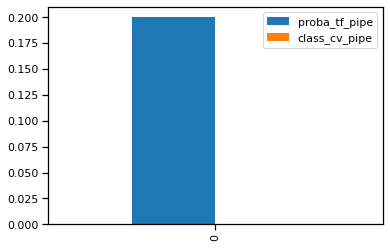

In [201]:
pred_plot_df.plot(kind='bar');